![](https://brandingmonitor.pl/wp-content/uploads/2019/01/new-rebranding-sgh-nowe-logo.png)

Szkoła Główna Handlowa w Warszawie

Optymalizacja ilości analityków firmy STTAS EUROPE sp. z o.o.

234060-0723 Zaawansowane modelowanie symulacyjne

- Uladzislau Darhevich 108519

# Podsumowanie

**Optymalna ilość analityków dla nowego działa klasyfikacji wynosi 6, ilość TA - 2.**


# Opis organizacji

STTAS Europe, a UPS company koncentruje się na dostarczaniu globalnego zarządzania zgodnością z przepisami handlowymi ([Trade Compliance](https://flashglobal.com/what-is-trade-compliance/)) i usług, takich jak klasyfikacja, określanie pochodzenia lub audyt zgodności celnej, a także usług konsultingowych w zakresie importu i eksportu dla klientów na całym świecie. 

Firma STTAS świadczy swoje usługi dużym międzynarodowym korporacjom, ma siedzibę w Warszawie, zatrudnia ponad 120 pracowników, należy do korporacji UPS.

# Opis problemu

Dział klasyfikacji zajmuje się tym, że przepisuję [kody taryfowe](https://en.wikipedia.org/wiki/Harmonized_System) do różnych towarów klientów zgodnie z systemem [TARIC](https://pl.wikipedia.org/wiki/TARIC). Kod TARIC jest zdefiniowany jako kod taryfowy przeznaczony do klasyfikacji towarów w urzędzie celnym. Jego ostatecznym celem jest zgłaszanie towarów, obliczanie należności celnych i rejestracja danych statystycznych. Jego rozporządzenie przechodzi przez Światową Organizację Celną (WCO). W przeciwieństwie do innych podobnych kodów zawiera informacje na temat warunków wymiany towarów na innych rynkach.

Klient requestuje części które potrzebują klasyfikację. **RID (request ID)** to zbiór zawierający kilka(dziesiąt) takich części.

Żeby poprawnie zaklasyfikować towar **Analityk** wyjaśnia funkcję towaru, cechy, materiał, dla czego jest używany, częścią czego jest, gdzie jest używany i przepisuje kod. Też analityk piszу krótki tekst, który nazywa się Audit Trail, w którym opisuje logikę dlaczego został użyty ten lub inny kod. 

**Technical Advisor (TA)** jest bardziej doświadczonym analitykiem, który sprawdza klasyfikację dostarczoną przez analityka. Jeżeli wszystko zrobione poprawnie, TA zatwierdza kod i opis, RID z kodami idzie do klienta. Jeżeli nie, to analityk otrzymuje *"failed review"* i musi zaklasyfikować towar jeszcze raz.

Firma podpisała umowę z nowym klientem i chce utworzyć nowy dział klasyfikacji. Należy określić, ilu nowych pracowników musi w nim pracować, aby spełnić wymagania klienta, aby średni czas oczekiwania wykonania RID nie przekraczał 120 minut. 

# Wyniki analizy

In [1]:
#import bibliotek
import simpy
import random
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

random.seed(42)

In [2]:
#lista RID_wait_times zawira czas oczekiwania na zrobinie RIDu
RID_wait_times = []

Klas `Company` obejmuje:

- complete_RID - generuje czas potrzebny na wykonanie jednego RIDa. RID może składać się z 1 części, a może ze 100. Rozkład normalny dobrze opisuje przeciętny czas wykonania;
- check_RID - TA sprawdza RID. Rozkład normalny dobrze opisuje przeciętny czas sprawdzania RIDa;
- fix_failes - jeżeli analityk otrzymał failed review, to musi jeszcze raz zrobić RID i poprawić błędy.

Funkcja `make_request` generuje zdarzenia. Prawdopodobieństwo otrzymać fail jest około 10%.

In [3]:
class Company(object):   

    def __init__(self, env, num_analysts, num_ta):
        self.env = env
        self.analyst = simpy.Resource(env, num_analysts)
        self.ta = simpy.Resource(env, num_ta)

    def complete_RID(self, RID):
        yield self.env.timeout(random.uniform(30, 120)) #czas na jeden RID

    def check_RID(self, RID):
        yield self.env.timeout(random.uniform(5, 20)) #czas na sprawdzenie

    def fix_failes(self, RID):
        yield self.env.timeout(random.uniform(5, 20)) #czas na poprawienie błędów

def make_request(env, RID, company):
    
    arrival_time = env.now

    with company.analyst.request() as request:
        yield request
        yield env.process(company.complete_RID(RID))

    with company.ta.request() as request:
        yield request
        yield env.process(company.check_RID(RID))
    
    if random.choices([True, False], weights=[0.1, 0.9]): 
        with company.analyst.request() as request:
            yield request
            yield env.process(company.fix_failes(RID))

    # Zakończony i sprawdzony RID idzie do Klienta
    RID_wait_times.append(env.now - arrival_time)


Oprócz biura w Warszawie istnieją również biura w innych częściach świata, dlatego usługi świadczone są praktycznie 24 godziny na dobę. Są jednak małe okna i dlatego przed rozpoczęciem pracy w biurze może zgromadzić się kilka części. Intensywność pojawiania się nowych RIDów dość skomplikowana, zależy od dnia tygodnia i kraju, z którego pochodzi. Średnio nowy RID pojawia się co 30 minut.

In [4]:
def run_classification(env, num_analysts, num_ta):
    company = Company(env, num_analysts, num_ta)

    #od wczoraj lub innego biura
    for RID in range(random.randint(1, 20)):
        env.process(make_request(env, RID, company))

    while True:
        yield env.timeout(30)

        RID += 1
        env.process(make_request(env, RID, company))

In [5]:
#średni czas oczekiwania
def get_average_wait_time(RID_wait_times):
    
    average_wait = statistics.mean(RID_wait_times)
    return average_wait

In [6]:
def simulate(qty_analyst, qty_ta):
    # Setup
    num_analysts, num_ta = qty_analyst, qty_ta

    # Run
    random.seed(42)
    env = simpy.Environment()
    env.process(run_classification(env, num_analysts, num_ta))
    env.run(until=480) #dzień roboczy trwa 8 godzin

    # Rezultat
    wtime = get_average_wait_time(RID_wait_times)
    
    return wtime

Najpierw ustalono, jak zmienia się średni czas oczekiwania w zależności od liczby analityków. Na tym etapie przyjęto liczbę TA = 2 z danych historycznych.

In [7]:
results = pd.DataFrame(columns=['Liczba analityków', 'Liczba TA', 'Czas oczekiwania'])

In [8]:
num_of_analyst = np.linspace(2, 15, 14)
num_of_ta = 2

In [9]:
for i in num_of_analyst:
        results = results.append({
                            'Liczba analityków' : i,
                            'Liczba TA' : num_of_ta,
                            'Czas oczekiwania' : simulate(i, num_of_ta)}, ignore_index=True)

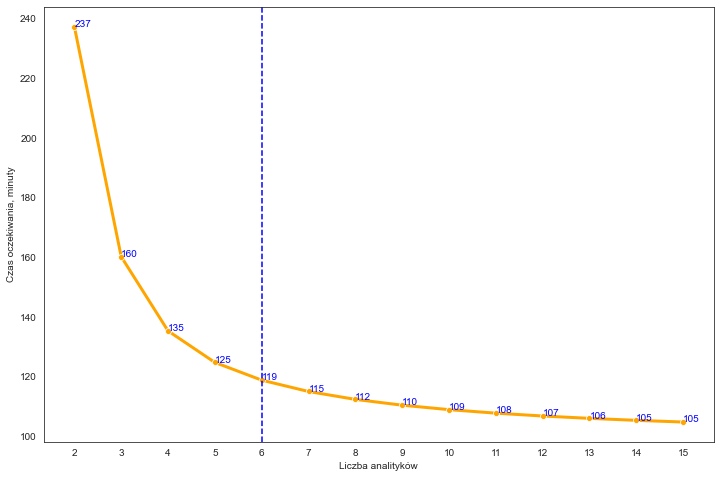

In [10]:
plt.figure(figsize=(12, 8))
sns.set_style("white")

g1 = sns.lineplot(data=results, x='Liczba analityków', y = 'Czas oczekiwania',
                 color='orange', linewidth=3, marker='o');
for x, y in zip(results['Liczba analityków'], results['Czas oczekiwania']):
        g1.text(x, y, f'{y:.0f}', color='blue')
g1.axvline(x=6, color='blue', linestyle='--')
g1.set(xlabel="Liczba analityków", ylabel = "Czas oczekiwania, minuty")
g1.set_xticks(num_of_analyst);
plt.savefig("Rys_1.png")

Z wykresu widać, że jeżeli zatrudnić co najmniej 6 analityków oraz 2 TA średni czas oczekiwania będzie mniej niż 2 godziny. 

Dalej badano, czy zatrudnienie wększej ilości TA pomoże zmniejszyć średni czas oczekiwania.

In [11]:
num_of_analyst = 6
num_of_ta = np.linspace(2, 5, 4)

In [12]:
for i in num_of_ta:
        results = results.append({
                            'Liczba analityków' : num_of_analyst,
                            'Liczba TA' : i,
                            'Czas oczekiwania' : simulate(num_of_analyst, i)}, ignore_index=True)

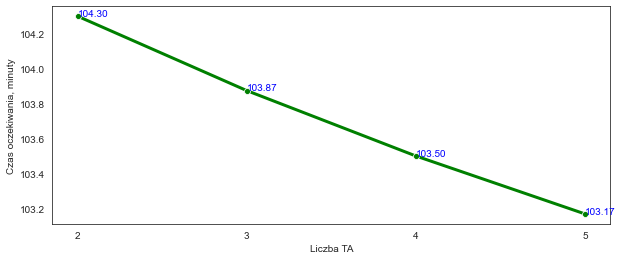

In [13]:
temp_d = results.iloc[14:, ]
plt.figure(figsize=(10, 4))
sns.set_style("white")

g2 = sns.lineplot(data=temp_d, x='Liczba TA', y = 'Czas oczekiwania',
                 color='green', linewidth=3, marker='o');
for x, y in zip(temp_d['Liczba TA'], temp_d['Czas oczekiwania']):
        g2.text(x, y, f'{y:.2f}', color='blue')
g2.set(xlabel="Liczba TA", ylabel = "Czas oczekiwania, minuty")
g2.set_xticks(num_of_ta);
plt.savefig("Rys_2.png")

# Analiza wrażliwości

Na podstawie badań można powiedzieć, że przy ceteris paribus zwiększenie ilości TA nie  wpływa na średni czas oczekiwania. 

# Wnioski i zalecenia

Według symulacji, optymalna liczba analityków i TA, w której średni czas oczekiwania nie przekracza 120 minut wynosi 6 analityków i 2 TA. Przy zwiększeniu ilości analityków (>6) średni czas oczekiwania zmniejsza się nieznacznie. Zwiększenie ilości TA nie wpływa na czas oczekiwania. Wyniki symulacji są zgodne z intuicją i mogą być wdrożone w praktyce. 

*PS Obecnie pracuję w STTASie. Wyniki są naprawdę bliskie rzeczywistości.*

Firmie STTAS sp z.o. zalecano:

- zatrudnić 6 analityków do nowego działu klasyfikacji;
- zatrudnić 2 TA.

# Bibliografia

- Jaya Zhané *SimPy: Simulating Real-World Processes With Python* https://realpython.com/simpy-simulating-with-python/
- Oficjalna dokumentacja SimPy https://simpy.readthedocs.io/en/latest/